## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Висков Василий

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from train_utils import train
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

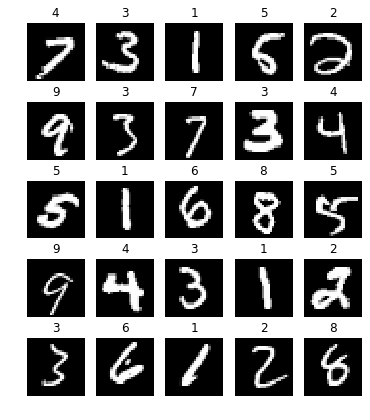

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

In [7]:
def make_linear(in_dim, out_dim, init_func):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    return layer

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [8]:
def dumb_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

def xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean=0, std=np.sqrt(d))
    
def xavier_init_uni(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    r = np.sqrt(6 / (weight.size()[0] + weight.size()[1]))
    weight.uniform_(-r, r)
    
def he_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / weight.size()[1]
    weight.normal_(mean=0, std=np.sqrt(d))

In [9]:
def init(init_f, activation):
    net = []
    net.append(make_linear(28*28, 500, init_f))
    net.append(activation)
    for i in range(8):
        net.append(make_linear(500, 500, init_f))
        net.append(activation)
    net.append(make_linear(500, 10, init_f))
    net.append(nn.LogSoftmax(dim=1))
    net = nn.Sequential(*net)

    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = net(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()

In [10]:
init(dumb_init, nn.Tanh())

forward 0.9911178946495056
forward 0.9849492311477661
forward 0.9818376302719116
forward 0.9814091324806213
forward 0.9819117188453674
forward 0.9817802309989929
forward 0.9812480211257935
forward 0.9811207056045532
forward 0.98176509141922
forward 0.9820852279663086
backward 0.06766462326049805
backward 0.02133265882730484
backward 0.06838785111904144
backward 0.22527703642845154
backward 0.8670240044593811
backward 2.834733486175537
backward 10.273340225219727
backward 36.58984375
backward 121.4756088256836
backward 368.2381896972656


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [11]:
init(xavier_init, nn.Tanh())

forward 0.9911178946495056
forward 0.6431612372398376
forward 0.4945939779281616
forward 0.414847195148468
forward 0.3618583381175995
forward 0.32764050364494324
forward 0.3013302981853485
forward 0.27729305624961853
forward 0.25727251172065735
forward 0.2431078851222992
backward 0.037101082503795624
backward 0.00655546085909009
backward 0.006168666295707226
backward 0.005652951542288065
backward 0.005196122918277979
backward 0.004604946821928024
backward 0.004000114277005196
backward 0.0034064839128404856
backward 0.0029050465673208237
backward 0.0019534029997885227


In [12]:
init(xavier_init_uni, nn.Tanh())

forward 0.9911178946495056
forward 0.6457603573799133
forward 0.4927022457122803
forward 0.4114105999469757
forward 0.3654421269893646
forward 0.32488396763801575
forward 0.2965313494205475
forward 0.27433833479881287
forward 0.2563321590423584
forward 0.23994743824005127
backward 0.034492358565330505
backward 0.006334655452519655
backward 0.006015283055603504
backward 0.005294464994221926
backward 0.00492500327527523
backward 0.004488176666200161
backward 0.003991901874542236
backward 0.003378329798579216
backward 0.0026925643905997276
backward 0.0017895973287522793


In [13]:
init(he_init, nn.Tanh())

forward 0.9911178946495056
forward 0.7133376598358154
forward 0.6287379860877991
forward 0.5980857610702515
forward 0.5735916495323181
forward 0.5656812787055969
forward 0.5619394779205322
forward 0.5616397857666016
forward 0.5607326030731201
forward 0.5602253079414368
backward 0.057943426072597504
backward 0.006881422363221645
backward 0.007185649126768112
backward 0.007101927883923054
backward 0.007153415121138096
backward 0.0070766881108284
backward 0.007645777892321348
backward 0.0070100100710988045
backward 0.006445861421525478
backward 0.005535684991627932


In [14]:
init(he_init, nn.ReLU())

forward 0.9911178946495056
forward 0.8132347464561462
forward 0.8529465794563293
forward 0.8275061249732971
forward 0.793236494064331
forward 0.7865689396858215
forward 0.8209285736083984
forward 0.8052184581756592
forward 0.7536885142326355
forward 0.7366517186164856
backward 0.09176450222730637
backward 0.010683217085897923
backward 0.009456506930291653
backward 0.008887885138392448
backward 0.008650781586766243
backward 0.008236189372837543
backward 0.007963346317410469
backward 0.0074820127338171005
backward 0.006683022249490023
backward 0.006286008283495903


<i> 1.4 Сделайте выводы по первой части </i>

При инициализации дисперсия активации стала примерно нулевой, в то время как градиент стал колоссальным.
Xavier хорошо отрабатывает, т.к. нечетный tanh в нуле имеет линейную природу. He же хорошо работает для несимметричных функций в нуле (ReLU), соответсвенно, полученные результаты (дисперсия градиента упала до нуля, а активации стали одинаковыми) естественны.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [15]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()        
        self.lin = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.ones_like(self.lin.weight) * self.p
        
        if self.training:
            mask = torch.ones_like(self.lin.weight) * self.p
            mask.bernoulli_()
            
        mask.detach_()

        output = torch.mm(x, (self.lin.weight*mask).transpose(0, 1))+self.lin.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [16]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.Dropout(0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 9... (Train/Test) NLL: 0.589/0.327	Accuracy: 0.848/0.919


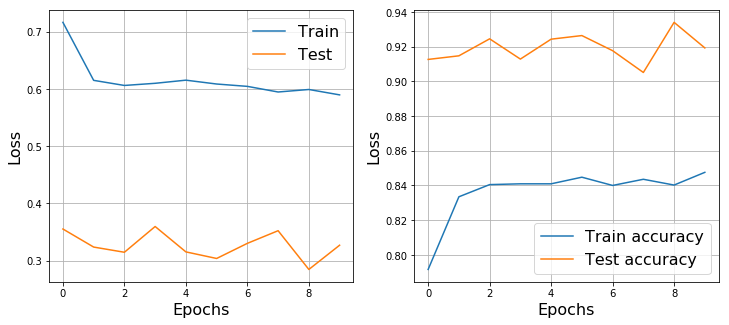

In [17]:
infoDO = train(net, train_loader, test_loader, 10, 0.01, device='cuda')

In [18]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(DropConnect(in_dim, out_dim, p=0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 9... (Train/Test) NLL: 0.245/0.147	Accuracy: 0.938/0.963


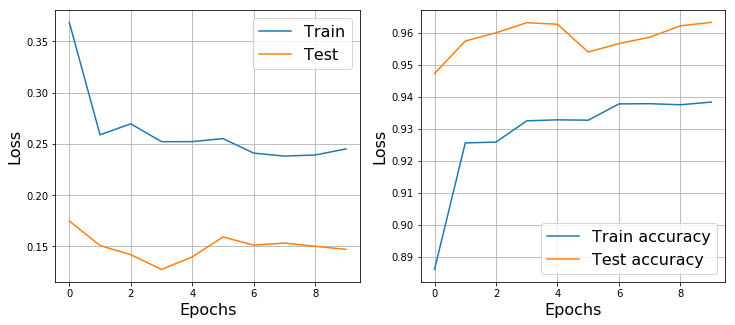

In [19]:
infoDC = train(net, train_loader, test_loader, 10, 0.01, device='cuda')

<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

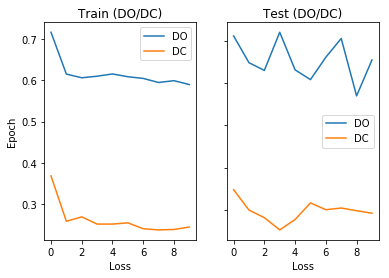

In [20]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(infoDO[0], label='DO')
axs[0].plot(infoDC[0], label='DC')
axs[0].set_title('Train (DO/DC)')
axs[0].legend()

axs[1].plot(infoDO[1], label='DO')
axs[1].plot(infoDC[1], label='DC')
axs[1].set_title('Test (DO/DC)')
axs[1].legend()

for ax in axs.flat:
    ax.set(xlabel='Loss', ylabel='Epoch')

for ax in axs.flat:
    ax.label_outer()

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

DropConnect показал себя лучше DropOut'a, обе сети за 10 эпох не переобучились (и на большее число эпох их должно хватить, конечно).

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [21]:
class LayerNormalization(nn.Module):
    def __init__(self, num_features, b=0.05, gamma=1.2):
        super().__init__()
        self.b = torch.zeros(num_features) + b
        self.gamma = gamma

    def forward(self, X):
        output = (X - X.mean(1).repeat(X.size()[1], 1).T) / (X.std(1).repeat(X.size()[1], 1).T + 0.01)
        output *= self.gamma
        output += self.b.repeat(X.size()[0]).view(X.size()[0], -1)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [22]:
net = [Flatten()]

sizes = [28 ** 2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.BatchNorm1d(num_features=out_dim, affine=False))
    net.append(nn.ReLU())
    
net.append(nn.BatchNorm1d(num_features=sizes[-1]))
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(dim=1))
net = nn.Sequential(*net)

Epoch 9... (Train/Test) NLL: 0.023/0.069	Accuracy: 0.992/0.982


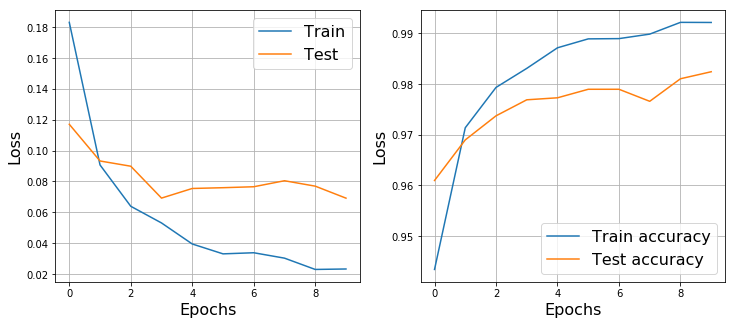

In [23]:
infoBN = train(net, train_loader, test_loader, 10, 0.005, device='cuda')

In [24]:
net = [Flatten()]

sizes = [28 ** 2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(nn.Linear(in_dim, out_dim))
    net.append(LayerNormalization(num_features=out_dim))
    net.append(nn.ReLU())
    
net.append(LayerNormalization(num_features=sizes[-1]))
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(dim=1))
net = nn.Sequential(*net)

Epoch 9... (Train/Test) NLL: 0.029/0.077	Accuracy: 0.991/0.979


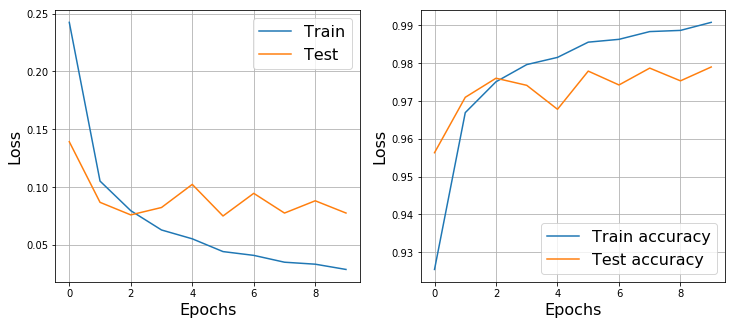

In [25]:
infoLN = train(net, train_loader, test_loader, 10, 0.005, device='cpu')

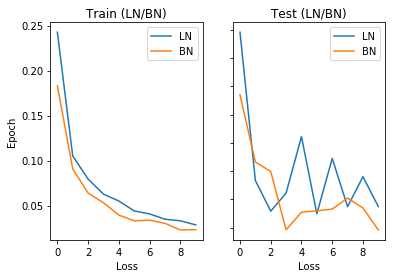

In [26]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(infoLN[0], label='LN')
axs[0].plot(infoBN[0], label='BN')
axs[0].set_title('Train (LN/BN)')
axs[0].legend()

axs[1].plot(infoLN[1], label='LN')
axs[1].plot(infoBN[1], label='BN')
axs[1].set_title('Test (LN/BN)')
axs[1].legend()

for ax in axs.flat:
    ax.set(xlabel='Loss', ylabel='Epoch')

for ax in axs.flat:
    ax.label_outer()

<i> 3.3 Сделайте выводы по третьей части </i>

Обучение с BatchNorm и LayerNorm проходит лучше, чем обучение с DropOut/DropConnect (loss на тесте 0.069/0.077 против 0.327/0.147).

Если сравнивать BatchNorm и LayerNorm, то первая нормализация показала результат лучше и на обучении, и на валидации.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: